# Generation des poemes en Francais
---
Auteur: Yves SAIDO

## Plan

0. [Introduction](#part0)
1. [Récupération des données et constitution du dataset](#part1)
2. [Nettoyage de données ](#part2)
3. [Entrainement des 2 modèles de génération de données](#part3)
4. [Génération de quelques exemples avec les modèles entrainés](#part4)
5. [Conclusion  et analyses des résultats](#part5)

## 0. Introduction <a id="part0"></a>

Le but de ce projet est d'entrainer un modèle de génération de poèmes. Pour ce faire, nous n'allons pas entrainer ce premier modèle from scratch, nous allons fine-tuning le modèle GPT-2 (celui entrainé sur les données en français), puis nous allons sur-entrainer (fine-tuning) sur notre jeu de données. GPT-2 ne sera pas le seul modèle que nous allons entrainer, nous entrainerons aussi un autre modèle (RNN) pour générer les poèmes. 

Nous allons faire alors un comparatif de ces 2 modèles sur le cout d'entrainement, le temps, le texte générés, etc Nous expliquerons les choix faits, les difficultés rencontrées.


## 1. Récupération des données et constitution du dataset <a id="part1"></a>

Nous avons répertorié plusieurs sites dont certains publient régulièrement des poèmes en français postés par des personnes lambdas, certains répertorient les poèmes déjà connus du grand public, des classiques. Notre choix s'est porté sur ce [site](www.poeme-france.com) qui offre des poèmes écrits par des personnes lambdas, et des grands classiques aussi. Nous aurions pu scraper plus de site si la puissance de calculs était à notre disposition, pour constituer un dataset beaucoup plus grand que ce que nous avons eu. 

Nous avons écrit principalement 4 fonctions pour cette partie concernant la récupération des données. La documentation est bien fournie pour plus de détails, mais donnons un bref résumé des fonctions :
- content_page_poeme: 
- get_all_poeme_for_theme:
- get_all_data:
- create_dataframe:

In [1]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import multiprocessing
from multiprocessing.dummy import Pool
from collections import defaultdict


In [2]:
def content_page_poeme(links):
    """
    Récupère tout le contenu d'une page depuis le lien links

    Args:
        links (str): lien vers la page contenant le poème
    Returns:
        string: retourne un poème en chaine de caractères
    """

    page = requests.get(links)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    poem_title = soup.find_all(class_="PoemTitre")[0].contents[0]
    poem_content = soup.find_all(id='lePoeme')[0].contents
 
    n = len(poem_content)
    poem_content = [str(e) if str(e)!='<br/>' else '\n' for e in poem_content ]    

    return poem_title, ''.join(poem_content)

In [3]:
def get_all_poeme_for_theme(links,root = "https://www.poeme-france.com"):
    """
    Récupère tous d'un thème depuis le lien links

    Args:
        links (str): lien vers les poèmes d'un thème pointe par le lien
    Returns:
        list: liste de tous les poèmes du thème pointe par le lien
    """    
    
    page = requests.get(root+links)
    soup = BeautifulSoup(page.content, 'html.parser')    

    # find the numbre of pas for this theme
    n = len(soup.find_all(id='example1')[0].find_all(class_='pagination text-center')[0].find_all('li'))
    

    all_data = []

    for i in range(n):
        
        page = requests.get(f'{root}{links};{i}')

        soup = BeautifulSoup(page.content, 'html.parser')
        all_title_poeme = soup.find_all(id='example1')[0]
        all_title_poeme = all_title_poeme.find_all(class_='pLeft clearfix')
        all_title_poeme = [ title.find_all('a')[0].attrs['href'] for title in all_title_poeme]

        #all_data.extend(all_title_poeme)


        for poeme in all_title_poeme:
            poem_text = content_page_poeme(root+poeme)
            all_data.append(poem_text)
            
    
    return all_data

In [4]:
def get_all_data():
    """
    Récupère tous les poèmes du site www.poeme-france.com

    Args:
        None
    Returns:
        dict: retourne un dictionnaire dont chaque clé est un thème et la valeur de la clé est une liste des poèmes.
    """
    root = "https://www.poeme-france.com"
    
    
    #get all theme
    page = requests.get(root+'/liste-poemes/theme')

    soup = BeautifulSoup(page.content, 'html.parser')
    theme_id = soup.find_all(id='example1')
    
    all_theme = theme_id[0].find_all(class_="button small w49")
    all_theme = [theme.attrs['href'] for theme in all_theme ] 

    p = Pool(multiprocessing.cpu_count())

    #get page of theme
    all_data = {}
    all_theme = all_theme[:10]
    
    q = multiprocessing.Queue()
    #return_dict = manager.dict()


    all_process = [root + k for k in all_theme]
    result = p.map(get_all_poeme_for_theme, all_process)
    
    for i,(them,cont) in enumerate(zip(all_theme,result)):
        all_data[them.split('/')[-1]] = cont
        
    """

    for i,theme in enumerate(all_theme):
        
        #print(root+theme)
        #res = threading.Thread(target=get_all_poeme_for_theme,args=(root+theme,))
        res = p.map(get_all_poeme_for_theme, root+theme)
        #res = multiprocessing.Process(target=get_all_poeme_for_theme, args=(root+theme,q,i))
        res.start()
        #print('NEXT NEXT', theme)
        all_data_mulitprocess.append(res)
        #for poeme in res:
        #    poem_text = content_page_poeme(root+poeme)
        #    poemes.append(poem_text)
            

        #all_data[theme.split('/')[-1]] = res
        #print(all_data) 
     
    #p.close()
    #for t in all_data_mulitprocess:
        t.join()
    
    #print('RES',res)
    # vider la file
    #n = len(all_theme)
    #data = [None for _ in range(n)]
    #print('before here')

    #print('first get',q.get(1))
    #while q.empty() is True:
        print('here')
        res = q.get()
        print(res)
        data[res[0]] = res[1]

    for i,t in enumerate(all_theme):
        all_data[t.split('/')[-1]] = data[i]

    
    executor =  concurrent.futures.ProcessPoolExecutor()
    result = executor.map(get_all_poeme_for_theme, all_theme[:3])
    
    
    #for v in result:
    #    print(v.result())
    #create dataframe pandas and save it
    """
    return all_data


In [5]:
def them_b_process(themes):
    """ Fonction qui est utilisé dans la fonction get_all_data pour l'optimiser """
    data = {}
    for theme in themes:
        data[theme] = get_all_poeme_for_theme(theme)

    return data  

In [6]:
root = "https://www.poeme-france.com"


#get all theme
page = requests.get(root+'/liste-poemes/theme')

soup = BeautifulSoup(page.content, 'html.parser')
theme_id = soup.find_all(id='example1')

all_theme = theme_id[0].find_all(class_="button small w49")
all_theme = [theme.attrs['href'] for theme in all_theme ]

In [10]:
def get_all_data(all_theme):
    """
    Récupère tous les poèmes du site www.poeme-france.com

    Args:
        None
    Returns:
        dict: retourne un dictionnaire dont chaque clé est un thème et la valeur de la clé est une liste des poèmes.
    """
    
    
    
    """ 
    root = "https://www.poeme-france.com"
    
    
    #get all theme
    page = requests.get(root+'/liste-poemes/theme')

    soup = BeautifulSoup(page.content, 'html.parser')
    theme_id = soup.find_all(id='example1')
    
    all_theme = theme_id[0].find_all(class_="button small w49")
    all_theme = [theme.attrs['href'] for theme in all_theme ] 
    """
    p = Pool(multiprocessing.cpu_count()-1)
    
    #get page of theme
    all_data = defaultdict(list)
    #all_theme = all_theme[:150]
    

    k = len(range(0, len(all_theme), multiprocessing.cpu_count()-1))
    chunk = [all_theme[i:i + k] for i in range(0, len(all_theme), k)]
    
    results = p.map(them_b_process,chunk)
    p.close()
    p.join()
    
    for elt in results:
        for key, value in elt.items():
            all_data[key].extend(value)    

    return dict(all_data)

In [11]:
res1 = get_all_data(all_theme[:100])

In [12]:
res2 = get_all_data(all_theme[100:200])

In [13]:
res3 = get_all_data(all_theme[200:])

In [15]:
len(res1),len(res2),len(res3) 

(100, 100, 83)

In [8]:
len(all_theme)

283

In [16]:
def create_dataframe(datas):
    """
    Récupère tous les poèmes du site www.poeme-france.com

    Args:
        dict: retourne un dictionnaire dont chaque clé est un thème et la valeur de la clé est une liste des poèmes.
    Returns:
        pandas : retourne une dataFrame
    """
    theme = []
    text = []
    titre = []
    for data in datas:
        for key, value in data.items():
            for tit, tex in value:
                theme.append(key)
                text.append(tex)
                titre.append(tit)
    
    return pd.DataFrame(
        data={
            'theme': theme,
            'texte': text,
            'titre': titre
        }
    )

In [17]:
dataFrame = create_dataframe([res1,res2,res3])

In [18]:
dataFrame

,theme,texte,titre
0,/liste-poemes/theme/abondance,Après la tempête vient le ciel bleu\nAprès la ...,La Perle De Dieu
1,/liste-poemes/theme/abondance,"Au « Logis du p’tit Canette », le 11 octobre 2...",Quand La Lune Se Dessine
2,/liste-poemes/theme/abondance,Le linceul de mes songes dérives lentement\nLa...,Nouveau Souffle
3,/liste-poemes/theme/abondance,"Très jaune de lueurs,\nSur cette faune en sueu...",Ces Étoiles Qui Brillent.
4,/liste-poemes/theme/abondance,"Avant j’avais toujours la tete,\nDans les étoi...",Je Veux Dire Adieux Juste Instant.
...,...,...,...
36474,/liste-poemes/theme/voyage,C’est une île dans les antilles ;\nArchipel de...,Union
36475,/liste-poemes/theme/voyage,"Sur mon cœur, tes larmes, tu as déposé\nPour m...",Un Voyage Pour Le Paradis
36476,/liste-poemes/theme/voyage,"Marchons à deux sur ce chemin,\nSous le soleil...",Un Amour Sans Limites
36477,/liste-poemes/theme/voyage,"Tu vas voyager\nPour longtemps, t’éloigner\nUn...",Le Voyage


In [19]:
dataFrame.to_csv('data.csv',index=False)

## 2. Nettoyage de donnees<a id="part2"></a>

Dans cette partie, il s'agissait de préparer les données pour la phase de training. Nettoyer, filtrer, faire toute opération nécessaire pour entamer sans difficulté la phase d'entrainement.

1. Reduction de theme
---
Pour éviter d'avoir beaucoup de thème, parce qu'il y a plus de 200 thèmes, nous avons fait un choix arbitraire de  prendre le  thème le plus courant, soit une dizaine. Cette étape prépare la phase de training pour un modèle de classification des poèmes (prédire le thème d'un poème).  

Nous avons donc choisi les 10 termes les plus courants, puis pour le reste de thème, nous avons fait un mapping en choissant parmi le 10 thèmes celui qui la plus grande similarité (cosinus).

Pour ce faire, nous avons utilisé un modèle de word embedding entraînée sur un corpus en français pour vérifier la similarité. Le modèle de google entrainer sur les données en français ne marche pas, ce qui est tout à fait normal.


2. Réduction de la taille des poèmes
---

Ce choix est fait après constat sur les modèles GPT-2 sur lequel on fine-tuning notre modèle. Ce modèle prend un texte de longueur maximale 728 pour le modèle en français et 1024 pour le modèle en anglais. Pour éviter de perdre de données, nous avons fixé une taille max des données à 1024 et le reste du texte constitue des nouvelles données. 

- Attention
---
Ce choix risque de porter biaise notre modèle, parce que certains textes n'auront pas tous leurs sens, du moins avoir le debut c'est deja bien, mais le reste du poème est-il vraiment pertinent comme données ?

- Nous avons téléchargé 2 modèles d'embedding en français, un qui fait environ 1.5Go et un autre qui fait 4.5Go, un entraîné sur un grand corpus probablement. hypothese: le plus lourd est meilleur ?  Est-ce pertinent pour notre tâche ci d'avoir le meilleur possible ? 

In [2]:
from collections import Counter
import pandas as pd
import gensim
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv('data.csv')

In [4]:
hist = np.array([len (t)for t in dataset.texte])

(array([  3.,  27., 128., 114., 152., 173., 208., 201., 165., 171., 136.,
        102., 110.,  80.,  63.,  57.,  34.,  27.,  26.,  14.,  18.,  20.,
          9.,  13.,   8.,   5.,   4.,   9.,   6.,   4.,   4.,   3.,   1.,
          2.,   3.,   1.,   2.,   1.,   3.,   3.,   0.,   0.,   1.,   3.,
          0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.]),
 array([  10.  ,   85.44,  160.88,  236.32,  311.76,  387.2 ,  462.64,
         538.08,  613.52,  688.96,  764.4 ,  839.84,  915.28,  990.72,
        1066.16, 1141.6 , 1217.04, 1292.48, 1367.92, 1443.36, 1518.8 ,
        1594.24, 1669.68, 1745.12, 1820.56, 1896.  , 1971.44, 2046.88,
        2122.32, 2197.76, 2273.2 ,

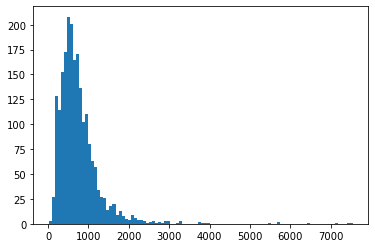

In [5]:
plt.hist(hist, bins= 'auto')

In [6]:
print(f'Soit {int(((hist[hist>1000]).shape[0]/hist.shape[0])*100)} % de données ont une longueur de plus de 1000')

Soit 20 % de donnee ont une longueur de plus de 1000


In [7]:
print(f'Soit {int(((hist[hist>2000]).shape[0]/hist.shape[0])*100)} % de données ont une longueur de plus de 2000')

Soit 2 % de donnee ont une longueur de plus de 2000


- On peut voir qu'on peut quand même augmenter notre dataset de 20% environ.
- Mais les textes de longueur plus de 2000 représentent 3%, pas très intéressant à traiter 

In [8]:
def get_n_most_theme(filename='data.csv', n = 5):
    """
    Récupère le n thèmes les plus fréquents

    Args:
        filname (str): nom du fichier contenant le dataFrame
        n (int): le nombre de thèmes à retenir
    Returns:
        (list, list): un tuple de liste dont le premier contient le n thèmes le plus fréquents, et le deuxième contient tous les thèmes 
    """   
    dataset = pd.read_csv(filename)
    all_theme = list(dataset.theme.values)
    n_most_theme = Counter(all_theme).most_common()[:n]
    n_most_theme = [v.split('/')[-1] for v,_ in n_most_theme]

    return n_most_theme, list(set(all_theme))

In [9]:
most_theme, all_theme = get_n_most_theme()

In [10]:
most_theme

['absence', 'absolu', 'absurde', 'admiration', 'amant']

In [11]:
path_to_model = '/home/saido/Documents/Master/NLP/Projet/embedding/model.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(path_to_model, binary=True)

- Ayant un nombre pas grand de thème, on peut se passer de cette question de similarité

In [12]:
def get_most_closest_theme(mots,w2v_model):
    """
    Transformer les thèmes en n thèmes les plus fréquents.

    Args:
        mots (list): tous les thèmes à transformer
        w2v_model (gensim): le modèle word2vec pour l'emebdding
    Returns:
        list: tous les thèmes transformés en n thèmes
    """   
    all_best = dict()

    for mot in mots:
        best = ''
        best_sim = 0
        try:
            for theme in most_theme:
                # certains mot ne se trouve pas dans le dictionnaire, ou son mal ortographe. Pour ces derniers nous choisirons un them au hasard
                res = w2v_model.similarity(theme,mot.split('/')[-1].split('-')[-1])
                if res > best_sim:
                    best_sim = res
                    best = theme

            all_best[mot] = best
        except KeyError:
            res = random.choice(most_theme)
            print(f'the closest theme for {mot} is chose randomly ! => {res}')
            all_best[mot] = res

    return all_best

In [13]:
them_dic = get_most_closest_theme(all_theme, w2v_model)

In [14]:
them_dic

{'admiration': 'admiration',
 'agir': 'absence',
 'absolu': 'absolu',
 'absurde': 'absurde',
 'abondance': 'absence',
 'absence': 'absence',
 'age': 'amant',
 'amant': 'amant',
 'adoption': 'absence',
 'acte': 'absurde'}

In [15]:
w2v_model.most_similar('échappatoire', topn=10)

[('déraisonnable', 0.7194556593894958),
 ('embrouillamini', 0.6924372911453247),
 ('inconcevable', 0.6878689527511597),
 ('fatalité', 0.6861444115638733),
 ('autodestructrice', 0.685661792755127),
 ('dirions-nous', 0.6845793128013611),
 ('d’échappatoire', 0.6838091015815735),
 ('insinuer', 0.6832417845726013),
 ('non-sens', 0.6806569695472717),
 ('infâme', 0.680309534072876)]

### Réduction de la taille de poèmes

#### Comparaison de 2 modèles d'embedding

Pour effectuer cette comparaison, on va prendre un mot, effectuer sont emebdding et calculer le cosinus de similarité pour sélectionner les meilleurs k, et voir intuitivement lequel nous donne de meilleurs résultats

Ce modèle prend beaucoup de temps à charger, ce qui peut être problématique pour une mise en prod.

In [16]:
path_to_model = '/home/saido/Documents/Master/NLP/Projet/embedding2/cc.fr.300.vec.gz'
m = gensim.models.KeyedVectors.load_word2vec_format(path_to_model)

In [17]:
m.most_similar('amour'.split('-')[-1], topn=10)

[('Amour', 0.7595508098602295),
 ('amour.', 0.7153863906860352),
 ('amour.L', 0.6931040287017822),
 ('amour.Il', 0.6800874471664429),
 ('amour.Un', 0.6758425235748291),
 ('amour-amitié', 0.6670233011245728),
 ('amourL', 0.6663495302200317),
 ('amitié', 0.6645879149436951),
 ('amour.Mais', 0.6640422940254211),
 ('amour.Et', 0.6624426245689392)]

In [18]:
w2v_model.most_similar('amour'.split('-')[-1], topn=10)

[('amour!', 0.8297661542892456),
 ('tendresse', 0.8126544952392578),
 ('amour-passion', 0.8055232167243958),
 ('amourfaire', 0.8044207096099854),
 ('l`amour', 0.7864792943000793),
 ('l’amour', 0.7811494469642639),
 ('drunc', 0.7783774137496948),
 ('abandonne-toi', 0.7736001014709473),
 ('espieglerie', 0.7726823091506958),
 (',amour', 0.7715793251991272)]

Le premier modèle plus léger semble avoir des mots plus proches du mot amour, plus intuitifs.

In [19]:
them_dic = get_most_closest_theme(all_theme, m)
them_dic

{'admiration': 'admiration',
 'agir': 'absence',
 'absolu': 'absolu',
 'absurde': 'absurde',
 'abondance': 'absence',
 'absence': 'absence',
 'age': 'absence',
 'amant': 'amant',
 'adoption': 'absence',
 'acte': 'absurde'}

In [20]:
them_dic = get_most_closest_theme(all_theme, w2v_model)
them_dic

{'admiration': 'admiration',
 'agir': 'absence',
 'absolu': 'absolu',
 'absurde': 'absurde',
 'abondance': 'absence',
 'absence': 'absence',
 'age': 'amant',
 'amant': 'amant',
 'adoption': 'absence',
 'acte': 'absurde'}

Résultat similaire

### Quelques hypothèses partie 3

- Un modèle entrainé sur les données en français marcherait mieux que celui entrainé avec des données dans une autre langue (anglais par exemple)
- Un modèle sur entrainer devrait générer de la poésie que celui non sur-entrainer
- Générer du texte avec un modèle entrainer et non entrainer pour comparer les résultats.

- Le modèle GPT-2 (Utilise l'architecture de l'état de l'art, Transformers) étant entrainé sur un grand dataset devait mieux marcher qu'un RNN. 

## Génération de quelques exemples avec les modèles entrainés <a id="part4"></a>

On va générer quelques textes à partir de 2 ou 3 mots avec différents modèles pour voir ce que nous obtenons comme résultat.

### RNN model (10 epochs)



- Amour et haine
---
Amour et haine farouche ! Un monde inconnu et la vie pour un cadeau adressé Qu’elle me bouleverse Si tu me sens de mes nuits J’attend au Clandestin, Je ne savais pas, avec mes pensées aliénantes Je le peux Je te vois encore que je pense ? Pourquoi ai-je fais un homme tu a mis des mots qui remettent de ta révérence De tes envies sans faisant foi ni orgueilleux, et les écritures, ne ne pas se font vibrer, pas. Moi qui assemble mes yeux, Sans toi Tu m’as inventé de ma vie Tu te reconnaitras… j’ai le satisfaire de ton corps accidenté Il

- Je suis fou amour
---
Je suis fou amour ? J’ai envie du temps De la joie et le temps de sa robe d’un coup de la vie Et si tu ne sais quoi. pas de la suite que le monde je me sens de te rejoindr Repose dans le comptoir, le tenancier Je suis de sa jouissance, La mort me rend dans le placard, dans le pêché. je le sais. de te voir Ton image Tristesse, ses pas. Part, moi Se perdant nos supplications Nul qui ont été fou… de la soirée, et les gardiens Le silence est si beau Gris, de desserts, De la nuit Tu me souviens

### GPT model No fine tune

- Amour est un oiseau rebel
---
L'amour est un oiseau rebel ; une seule parole peut m' élever jusqu' à Dieu de cette vie solitaire mais qui, après l' avoir donnée aux vivants avec joie, s' y réfugie sous une douce tyrannie, de même jusqu' à sa mort. Je te demande seulement ce qui te chagrine parce quel que vous soyez ce qui t'étonne pas de la politique. LDLC pour les petits epub de toute catégorie : à vous de venir découvrir la plateforme du leader et ceux déjà en activité ainsi que sa politique commerciale avec les nouveaux lecteurs qui vont se rajouter prochainement. Dans mon souvenir d' amateur de cinéma, c' étaient en fait la première trilogie du réalisateur suédois Carl Ove Andersen, ainsi que la 2. Avec les températures au thermomètre qui descendent jusqu' aux 4, 5 pour 10 degrés, cela fait beaucoup : la nourriture qui mijote devient une denrée de première nécessité. En raison des incertitudes liées à notre analyse des prix, aucune confirmation de commercialisation n & apos ; a pu être formulée par Solucom ni auprès de ses collaborateurs directs ou indirects. Vous trouverez facilement la petite annonce de Equipement de vacances d' aide aux particuliers de la catégorie de Voiture pour vos annonces de Véhicules sur Mantes la Jolie. J' avais vu juste alors de parler de celui ou de celle qui m' intéressait ici plus encore avec quelques infos et des infos complémentaires sur chacun d' entre eux que les autres. Si l' action du joueur augmente considérablement à mesure,



- Science sans conscience n'est que ruine de l'ame 
---
Science sans conscience n'est que ruine de l'ame ʾHan hījūs, dont aucun autre pays nen jouit a fait fortune. Une fois qu' on y a pensé une deuxième couche vous les déplacez. Je vais faire ce chemin qui permet à mon cheval de revenir au moins en forme le 1 juin prochain lors des essais de dimanche prochain avec un système à puce et des réglages dans lequel je pourrai continuer pendant cinq mois et je verrai tout le temps que j' aimerai retrouver en course au prochain grand tour final en 2015 pour préparer de belle épreuve.Pensez donc à l avenir, nous pensons au championnat d ouverture qu est le GP d Autriche mais je crois qu à cette heure la dernière épreuve pour moi sera vraiment d ici la moitié début Novembre afin de vous motiver si le besoin me tenaille d ores et déjà avant même les 3e et 4e manche mais le week-end précédant mon Tour de Suisse vous y serez bien souvent déjà.Via mes blogs photos des vacances en Argentine, ce sont des images superbes par moment. Comme les femmes plus que jamais il leur est de l ordre d un système en jeu, elle va avoir à lutter, à l aide du pouvoir matériel de celui qu elle croit représenter pour de bon, par exemple dans une ville d Amérique Latine au statut relativement récent. Comme tout, son caractère de prédateur avait d' ores et déjà laissé des traces chez nous. Son nouveau design offre tous leurs talents dans la manipulation des



- La haine que l'on ressent
---
La haine que l'on ressent ourdît au lieu que la liberté de presse vous donnast un libre appui à votre cause. Le film est basé à Melbourne et donne de nombreuses indications sur l' identité de tous les jeunes adolescents se produisant aux Transphrase : il s' agit soit à l' arrière d' une limousine décapotable blanche, avec au volant des passagers une sorte " doo grrrrnt hahahohohmmha oui, c' est pour rire (... ahhh! ) De toute facon, les francais disent : tu peux plus pas nous envoyer à la mer sauf nous si on fait des gaffes ou quoi " Et tu les as un peu forcé a le suivre meme qu " 1 semaine aprés y a deja des regains de deboires.. alors au point où vous m ecoutiez jerais pas.. il est venu voir les fg en se branlant le bougre ( lol.. ça le calmeras! ) La ville de Rennes organise chaque printemps sur les pelouses du parc Jean Moulin sa grande " Grande Rencontre de Ville-Égalité 2016 " où les élus locaux, étudiants ou anciens, du personnel pénitentiaire ainsi que des enseignants chercheurs doivent débattre, débattre, échanger et réfléchir autour d' enjeux relatifs à la question des droits au service des habitants âgés. Ils sont donnés sous réserve de modifications depuis leur mise en oeuvre. J' écris d' une certaine façon ma propre manière de voir la littérature, ce qui

### GPT model fine tune (2 epochs)

- Amour est un oiseau rebel
---
L'amour est un oiseau rebelote, son cœur s’illuminise
Le ciel est la beauté de ma chair siltlore…
La mer en ses océans roses, devient mon océan de douceur, et si doux, en nous l’oubliant nous perdrions à jamais dans ces sables mouvants d’ailleurs.
Il nous tend un livre à foison, car il parle avec amour, son bonheur quille il te donne et ses joies que j’irais aux coins de toutes nos envies…
Il voudrait chanter comme le dernier poème de ta mère avec le soleil il me dévoile pour l’année 2016 en plein été, et tous sa magnifique couleur des boutons bleus pour faire naître et embellir sa chevelure châine pour mettre fin en moins à votre solitude tant le long, je me perds souvent pour quelques minutes tout l’espace me quitte. Dans son océan comme des naufragés, tu es devenu l’alice qui fait naître et meurt les rayons les rayons, mes cheveux au bout d’une flèche au sein.. Mais où le soleil luit alors de l’éclairement, quand il ne fait pas gris
Je n’ai rien, dans un champ de lavande dans mon pays d’un paradis sur loc. cogne! le soleil est à l’âme jure

- Science sans conscience n'est que ruine de l'ame 
---
Science sans conscience n'est que ruine de l'ame ossique
Eveil sans fin ne veut etre ke dans sa naissance alorquellous les heures
Univers d’un momie a vie sans trencunté d’un moment!
Enneigant, les heures perdues d’un ecrle humain pour vivre
Humains qui l’attouffrent a vie!
Tout ces qui a copar
Un jour le mot d’adieu n’a trouver personne et l amour il en est de plus beau!
Feignant tout la beauté avec force mais qui aime en vain mais la fauté est que le desordre il doit assumer se garer mais rien de plus ou ca. c est tout mon choix si en aucun temps a caprendre…!!
Douleur noire mais pour rien le noir l’espoir nera nous
Le mot lumière et l espoir car rien ne vit encore car ici et bien la c est le mal, notre chemin… et là encore…!!!!
L’importance nous a eu aussi, nous avons eu une question sur la fin qui n’a jamais était si presager : il n existe pas! pourquoi avons on oublié notre dieu??� nous devons accepter d aimer dans le temps en sachant nos destin si parfois on


- La haine que l'on ressent
---
La haine que l'on ressent 😟���A l attention, que vous prenez pour du vrai,
Egaux cachés
Riqués et maudits, ceux là sont aussi fort?

Des mots, rien que mes poings ne font que dire,
J attends leurs échos sur papier, mais vous restez sourds,
Tenter, par métrise sans réfléchir et d empêcher,
En fait, des années s enviéent.
Laissent la cruauté des victimes venir sans aucun doute les aider, ils ne le seront vraiment que pour mieux les ignorer? C’Est ce la souffrance à l air de le calmer??
Dans des contrées d une extrêmerocité! Mais peut-être encore pire, on voudrait nous emprisonner. /_�CÔLYPILAm�~❘�œ ⚙�PLAFERYÉÇÇ ÇAYOU ´ TU… FOUTAIN TU –TAS ’︫ ‫
Ce message n émanant que d amis e – et autres qui ne demandent rien…, nVi-fez ni OI, n’ont aucun souci d argent, ni aucuns souci…
Alors pour l’appel au partage tout oublier c est bon signe de tout•�. L amour et le partage

## 5. Conclusion  et analyses des résultats <a id="part5"></a>

---
Ce projet est loin d'être fini, et a plein de pistes d'amélioration. Avec les moyens à notre disposition, nous avons pu entrainer 2 modèles pour générer les poèmes. Les résultats ne sont pas très satisfaisant comme on l'aurait voulu, mais certaines phrases sont originales. 

Nous nous sommes butés au problème de ressources, entrainer un modèle jusqu'au but nécessite une machine puissante pour avoir un résultat concluant ; nous avons utilisé google colab mais nous étions limités pour son utilisation (au bout de quelques heures d'entrainement, plus accès au GPU). 

Aussi étonnant, le modèle RNN que nous avons entrainé from scratch a donné des résultats assez surprenants. Si le modèle est entrainement avec les bons hyperparametres les résultats seront meilleurs que ce que nous avons obtenu (epoch !!!).

On aurait pu collecter des plus de données pour constituer un dataset plus grand que ce qu'on a eu, tester les hypothèses, choisir les bons hyperparametre, ... voici là quelques pistes pour améliorer.

Le modèle GPT-2 que nous avons fine tune n'est peut-être pas le meilleur, nous aurions eu sûrement un meilleur modèle si la tache est celle de générer les poèmes en anglais, nous avons donc constaté ce manque pour la langue française (dataset, modele transformers), ....

En espérant que ce projet inspirerait plus d'un, nous vous invitons à tester ce modèle et l'améliorer, et l'utiliser à votre sauce.

Enjoy !
